In [0]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
from scipy import misc
import numpy as np

In [0]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from skimage import io, transform

In [0]:
from google.colab import files
files.upload()

In [0]:
import pandas as pd
track = pd.read_csv('./genre_small.csv')

In [0]:
y = track.iloc[:,1:2].values
ID = track.iloc[:,0:1].values
y = y[2:,:]
ID = ID[2:,:]

label = {}
for i,j in zip(ID,y):
  label[str(i[0])] = j[0]

In [0]:
img_dir = os.listdir(8'./fma_spec')

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='19MxOn5NsxMccFIQwqukrzpJN2nNaXX_M',
                                    dest_path='./fma_spec.zip')

In [0]:
zip_ref = zipfile.ZipFile('./fma_spec.zip', 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

In [0]:
%rm fma_spec.zip

In [0]:
!ls fma_spec

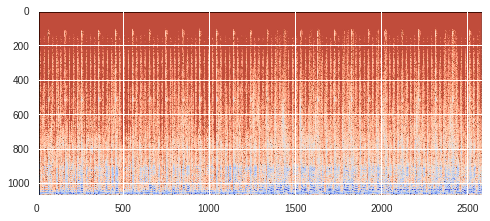

In [19]:
temp = cv2.imread('/content/fma_spec/100478.jpg')
plt.imshow(image)

In [0]:
def chop_image(path):
  img = misc.imread(path)
  height, width, channels = img.shape

  w = width // 10

  images = []

  for i in range(0,10):
    temp = img[:, (i*w):((i+1)*w), :]
    temp = cv2.resize(temp,(224,224))
    images.append(temp)
  return images

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


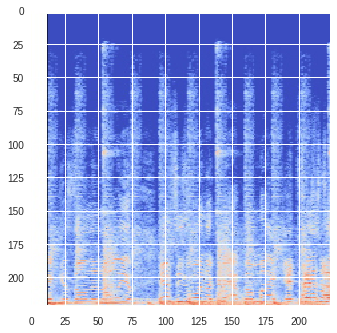

In [30]:
temp = chop_image('/content/fma_spec/100478.jpg')
#print(temp[0].shape)
plt.imshow(temp[0])

In [0]:
encoder = {}
encoder['Hip-Hop'] = 0
encoder['Pop'] = 1
encoder['Rock'] = 2
encoder['Experimental'] = 3
encoder['Folk'] = 4
encoder['Instrumental'] = 5
encoder['Electronic'] = 6
encoder['International'] = 7
decoder = {}
decoder[0] ='Hip-Hop' 
decoder[1] = 'Pop'
decoder[2] = 'Rock'
decoder[3] = 'Experimental'
decoder[4] = 'Folk'
decoder[5] = 'Instrumental'
decoder[6] = 'Electronic'
decoder[7] = 'International'

In [0]:
class datagen(Dataset):
  def __init__(self,label,image_dir,transform = None):
    self.img_dir = image_dir
    self.transform = transform
  def __len__(self):
        return len(os.listdir(self.img_dir))
  def __getitem__(self,idx):
    directory = os.listdir(self.img_dir)
    file_name = directory[idx]
    path = os.path.join(self.img_dir,file_name)
    
    image = chop_image(path)
    
    file_name = list(file_name)
    file_name = file_name[:-6]
    file_name = "".join(file_name)
    
    genre = label.get(file_name,'notfound')
    
    if self.transform:
      image = self.transform(image)
      
    if(genre == 'notfound'):
        print('notfound')
        return None,None
      
    return image,genre
    '''
    image = io.imread(path)
    image = image[:,:-2]
    image = image.reshape((len(image[:,0]),len(image[0,:]),1))
    file_name = list(file_name)
    file_name = file_name[:-6]
    file_name = "".join(file_name)
    genre = label.get(file_name,'notfound')
    if self.transform:
      image = self.transform(image)
    if(genre == 'notfound'):
        print('notfound')
   # print(genre)
    
    genre = encoder.get(genre)
    
    return image,genre


    genre1 = np.empty((8,1),np.int)
    for i in range(8):
        if(genre==i):
            genre1[i] = 1
        else:
            genre1[i] = 0
  
    '''

In [0]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
    ])

datagen_object = datagen(label,'./fma_spec',transform)

dataloader = DataLoader(datagen_object,batch_size = 32,shuffle = False)

In [0]:
test_size = 0.2
valid_size = 0.1
data_len = len(datagen_object)
indices = list(range(data_len))
np.random.shuffle(indices)
split1 = int(np.floor(valid_size * data_len))
split2 = int(np.floor(test_size * data_len))
valid_idx , test_idx, train_idx = indices[:split1], indices[split1:split2] , indices[split2:] 
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = DataLoader(datagen_object, batch_size=32 , sampler=train_sampler)
valid_loader = DataLoader(datagen_object, batch_size=32 , sampler=valid_sampler)
test_loader = DataLoader(datagen_object, batch_size=32 , sampler=test_sampler)
dataloaders = {'train':train_loader,'val':valid_loader}
dataset_sizes = {'train':27990,'test':7997,'val':3998}


In [0]:
resnet50 = resnet34(pretrained=False)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(nn.Linear(num_ftrs,256),nn.ReLU(),nn.Linear(256,8),nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
model_ft = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=3)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == ' train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                inputs = inputs.type(torch.cuda.FloatTensor)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    preds = preds.reshape(preds.size(0),-1)
                    
                    #print(outputs.shape,type(labels))
                    loss = criterion(outputs, labels)

                    #_, labels = torch.max(labels,1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss
            writer.add_scalar('./sanchit/scalar1', epoch_loss , epoch)
            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(),'./classifier{}'.format(best_acc))
    

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model